In [3]:
!wget https://hydranets-data.s3.eu-west-3.amazonaws.com/hydranets-data-2.zip && unzip -q hydranets-data-2.zip && mv hydranets-data-2/* . && rm hydranets-data-2.zip && rm -rf hydranets-data-2

--2024-10-15 10:50:08--  https://hydranets-data.s3.eu-west-3.amazonaws.com/hydranets-data-2.zip
Resolving hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)... 52.95.155.94, 3.5.224.123
Connecting to hydranets-data.s3.eu-west-3.amazonaws.com (hydranets-data.s3.eu-west-3.amazonaws.com)|52.95.155.94|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 812068227 (774M) [application/zip]
Saving to: ‘hydranets-data-2.zip’

hydranets-data-2.zi 100%[===================>] 774.45M  9.32MB/s    in 62s     

2024-10-15 10:51:10 (12.5 MB/s) - ‘hydranets-data-2.zip’ saved [812068227/812068227]



In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import os, glob
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [16]:
depth = sorted(glob.glob("nyud/depth/*.png"))
seg = sorted(glob.glob("nyud/masks/*.png"))
images = sorted(glob.glob("nyud/rgb/*.png"))

In [17]:
print(len(images))
print(len(seg))
print(len(depth))

1449
1449
1449


In [18]:
CMAP = np.load("cmap_nyud.npy")
print(len(CMAP))

256


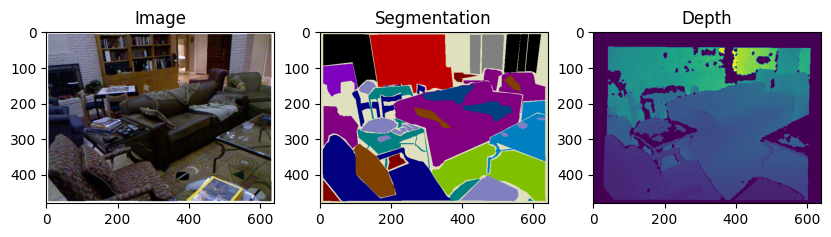

In [19]:
idx = np.random.randint(0, len(seg))

f, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 5))
ax0.imshow(Image.open(images[idx]))
ax0.set_title("Image")
ax1.imshow(CMAP[np.array(Image.open(seg[idx]))])
ax1.set_title("Segmentation")
ax2.imshow(Image.open(depth[idx]))
ax2.set_title("Depth")
plt.show()

In [20]:
print(np.unique(np.array(Image.open(seg[idx]))))
print(len(np.unique(np.array(Image.open(seg[idx])))))

[  0   1   4   5   6   7   9  17  19  20  37  38  39 255]
14


## Dataloader

In [24]:
data_file = "train_list_depth.txt"
with open(data_file, "rb") as f:
  datalist = f.readlines()
datalist = [x.decode("utf-8").strip("\n").split("\t") for x in datalist]
root_dir = "/nyud"
mask_names = ("segm", "depth")

print(datalist[0])

['rgb/000003.png', 'masks/000003.png', 'depth/000003.png']


In [25]:
datalist[0]

['rgb/000003.png', 'masks/000003.png', 'depth/000003.png']

In [26]:
abs_path = [os.path.join("nyud", rpath) for rpath in datalist[0]]
abs_path

['nyud/rgb/000003.png', 'nyud/masks/000003.png', 'nyud/depth/000003.png']

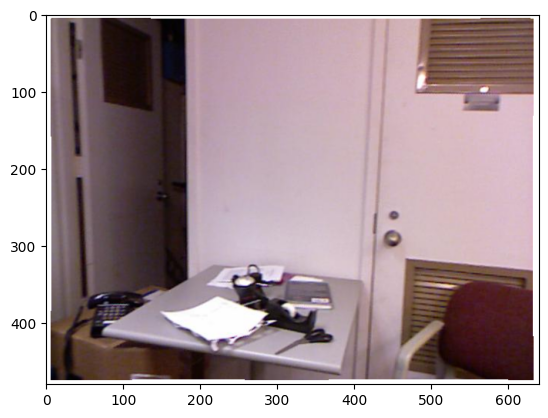

In [27]:
img_arr = np.array(Image.open(abs_path[0]))

plt.imshow(img_arr)
plt.show()

segm
nyud/masks/000003.png


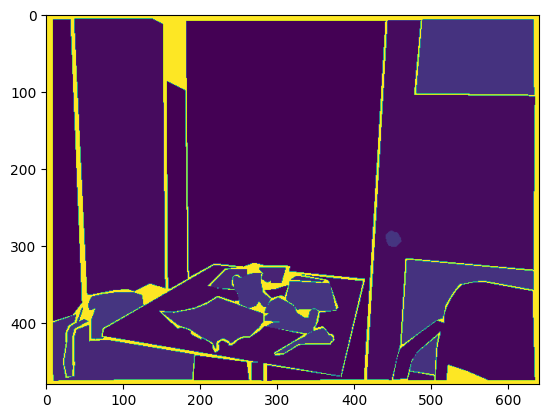

depth
nyud/depth/000003.png


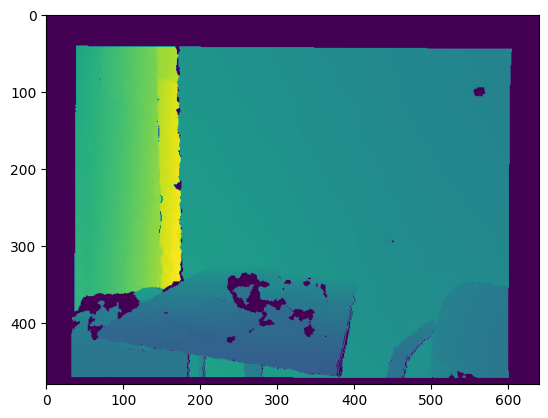

In [29]:
mask_names = ("segm", "depth")
for mask_name, mask_path in zip(mask_names, abs_path[1:]):
  print(mask_name)
  print(mask_path)
  mask = np.array(Image.open(mask_path))
  plt.imshow(mask)
  plt.show()

In [31]:
from torch.utils.data import Dataset

class HydranetDataset(Dataset):

  def __init__(self, data_file, transform=None):
    with open(data_file, "rb") as f:
      datalist = f.readlines()
    self.datalist = [x.decode("utf-8").strip("\n").split("\t") for x in datalist]
    self.transform = transform
    self.root_dir = "nyud"
    self.mask_names = ("segm", "depth")

  def __len__(self):
    return len(self.datalist)

  def __getitem__(self, idx):
    abs_paths = [os.path.join(self.root_dir, rpath) for rpath in self.datalist[idx]]
    sample = {}
    sample["image"] = np.array(Image.open(abs_paths[0]))

    for mask_name, maks_path in zip(self.masks_names, abs_pzths[1:]):
      mask = np.array(Image.open(mask_path))
      assert len(mask.shape) == 2
      sample[mask_name] = mask

    if self.transform:
      sample["names"] = self.mask_names
      sample = self.transform(sample)
      if "names" in sample:
        del sample["names"]

    return sample

### Normalization

In [41]:
from utils import Normalise, RandomCrop, ToTensor, RandomMirror
import torchvision.transforms as transforms

In [42]:
img_scale = 1.0 / 255
depth_scale = 5000.0

img_mean = np.array([0.485, 0.456, 0.406])
img_std = np.array([0.229, 0.224, 0.225])

normalise_params = [img_scale, img_mean.reshape((1, 1, 3)), img_std.reshape((1, 1, 3)), depth_scale]
transform_common = [Normalise(*normalise_params), ToTensor()]

In [43]:
crop_size = 400
transform_train = transforms.Compose([RandomMirror(), RandomCrop(crop_size)] + transform_common)
transform_val = transforms.Compose(transform_common)

In [44]:
train_batch_size = 4
val_batch_size = 4
train_file = "train_list_depth.txt"
val_file = "val_list_depth.txt"

In [45]:
from torch.utils.data import DataLoader

trainloader = DataLoader(
    HydranetDataset(train_file, transform=transform_train),
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)

valloader = DataLoader(
    HydranetDataset(val_file, transform=transform_val),
    batch_size=val_batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=False
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
